# First Exploratory Data Analysis of Crypto Data

## Plotting
* Plot data  in diffs
* Plot Correlations in diffs
* ACFs and CCFss in diffs
* Summary Statistics

## Goal: All things needed for a pre-causal analysis

In [32]:
import glob
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from statsmodels.tsa.stattools import acf, ccf, pacf
import plotly.express as px
import plotly.graph_objects as go

# Set style for better visualizations
sns.set_theme()
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [12, 6]

### Functions

In [46]:
# plotting time series data
def plot_time_series_data(data, symbol, column="close", title=None):
    fig = px.line(data[f'{symbol}USDT'], x="timestamp", y=column, title=title)
    fig.show()

In [36]:
def load_and_prepare_data(data_dir="../data/processed/"):
    # Load raw data
    all_data = {}
    returns_data = {}

    for file in glob.glob(os.path.join(data_dir, "*.parquet")):
        symbol = os.path.basename(file).split("_")[0]
        df = pq.read_table(file).to_pandas()

        # Calculate log returns
        df["log_returns"] = np.log(df["close"]/df["close"].shift(1))

        # Calculate simple returns
        df["simple_returns"] = df["close"].pct_change()

        # Calculate absolute difference
        df["price_diff"] = df["close"].diff()

        all_data[symbol] = df
        returns_data[symbol] = df[
            ["timestamp", "log_returns", "simple_returns", "price_diff"]
        ].copy()

    return all_data, returns_data

In [34]:
def plot_acf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot ACF for each cryptocurrency's returns/differences
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    for symbol, df in returns_data.items():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle(f"ACF Analysis of {diff_type} for {symbol}")

        series = df[diff_type].dropna()

        # ACF
        acf_values = acf(series, nlags=max_lags)
        ax1.stem(range(len(acf_values)), acf_values)
        ax1.axhline(y=0, linestyle="-", color="black")
        ax1.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.set_title(f"Autocorrelation Function")

        # PACF
        pacf_values = pacf(series, nlags=max_lags)
        ax2.stem(range(len(pacf_values)), pacf_values)
        ax2.axhline(y=0, linestyle="-", color="black")
        ax2.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.set_title(f"Partial Autocorrelation Function")

        plt.tight_layout()
        plt.show()

In [38]:
def plot_ccf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot CCF between pairs of cryptocurrencies
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    # Get all pairs of cryptocurrencies
    pairs = list(itertools.combinations(returns_data.keys(), 2))

    for symbol1, symbol2 in pairs:
        # Get the return series
        series1 = returns_data[symbol1][diff_type].dropna()
        series2 = returns_data[symbol2][diff_type].dropna()

        # Calculate CCF
        ccf_values = ccf(series1, series2, adjusted=False)

        # Plot
        plt.figure(figsize=(15, 5))
        plt.stem(
            range(-max_lags, max_lags + 1),
            ccf_values[max_lags - max_lags : max_lags + max_lags + 1],
        )
        plt.axhline(y=0, linestyle="-", color="black")
        plt.axhline(y=1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")
        plt.axhline(y=-1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")

        plt.title(f"Cross-Correlation of {diff_type}: {symbol1} vs {symbol2}")
        plt.xlabel("Lag")
        plt.ylabel("CCF")

        # Find significant lags
        threshold = 1.96 / np.sqrt(len(series1))
        sig_lags = np.where(np.abs(ccf_values) > threshold)[0] - max_lags
        if len(sig_lags) > 0:
            print(f"\nSignificant lags between {symbol1} and {symbol2}:")
            for lag in sig_lags:
                corr = ccf_values[lag + max_lags]
                if lag < 0:
                    print(
                        f"{symbol2} leads {symbol1} by {abs(lag)} periods "
                        f"(correlation: {corr:.3f})"
                    )
                elif lag > 0:
                    print(
                        f"{symbol1} leads {symbol2} by {lag} periods "
                        f"(correlation: {corr:.3f})"
                    )

        plt.tight_layout()
        plt.show()

### Plot timeseries data

In [47]:
# Load data
all_data, returns_data = load_and_prepare_data()
plot_time_series_data(all_data, "BTC", title="BTC Close Price")


## Cross-Correlation Analysis of Differences

## Run Analysis

ACF Analysis of Log Returns


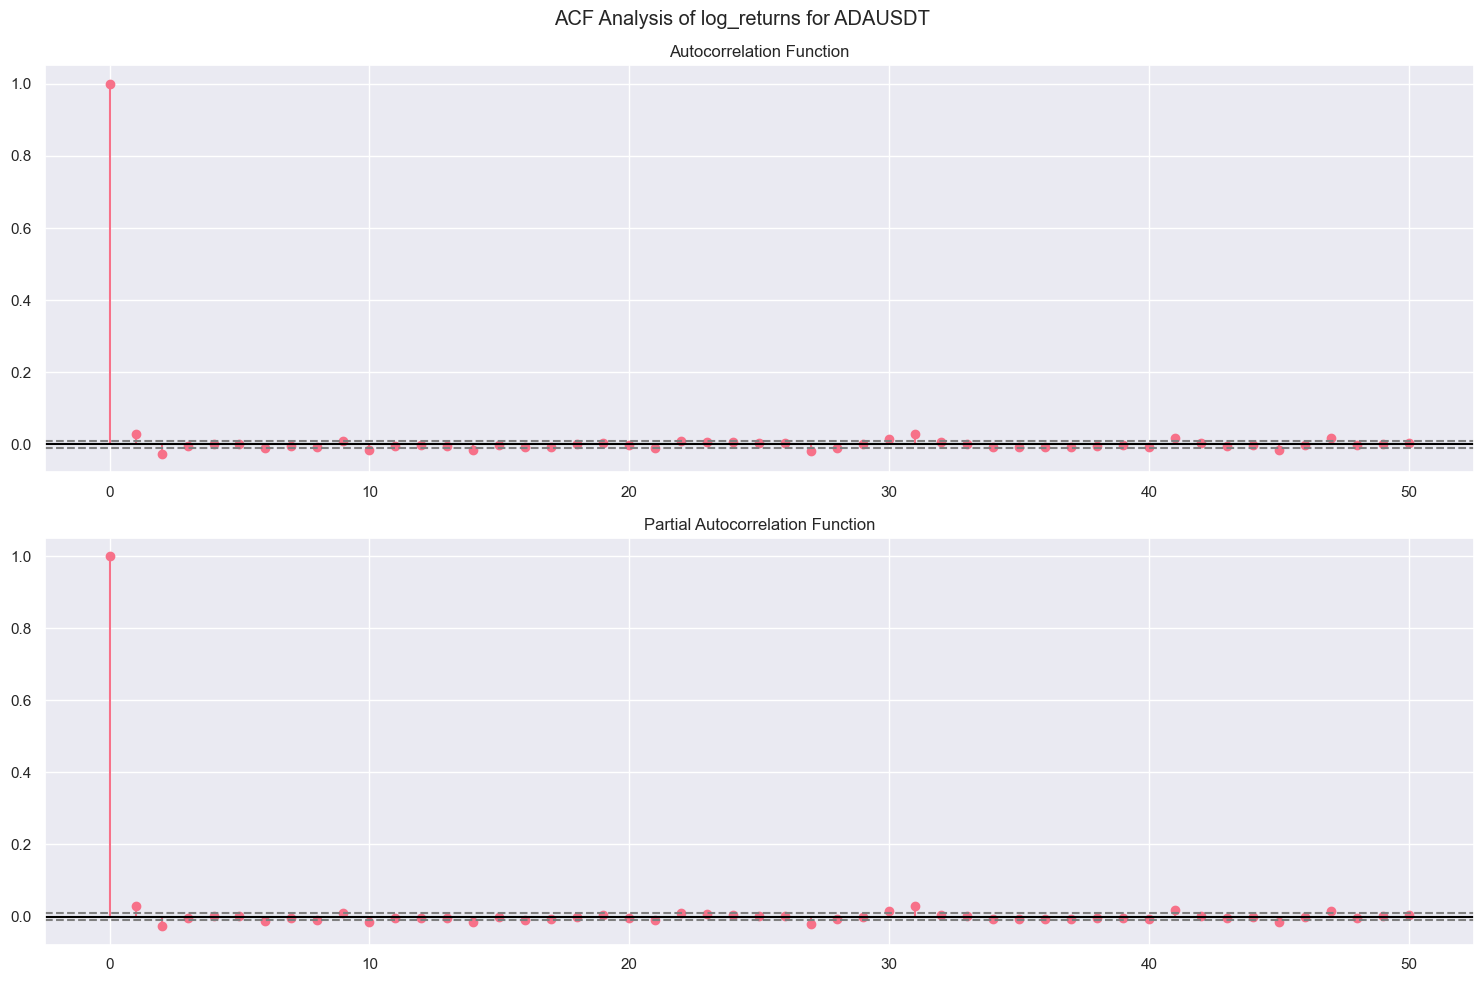

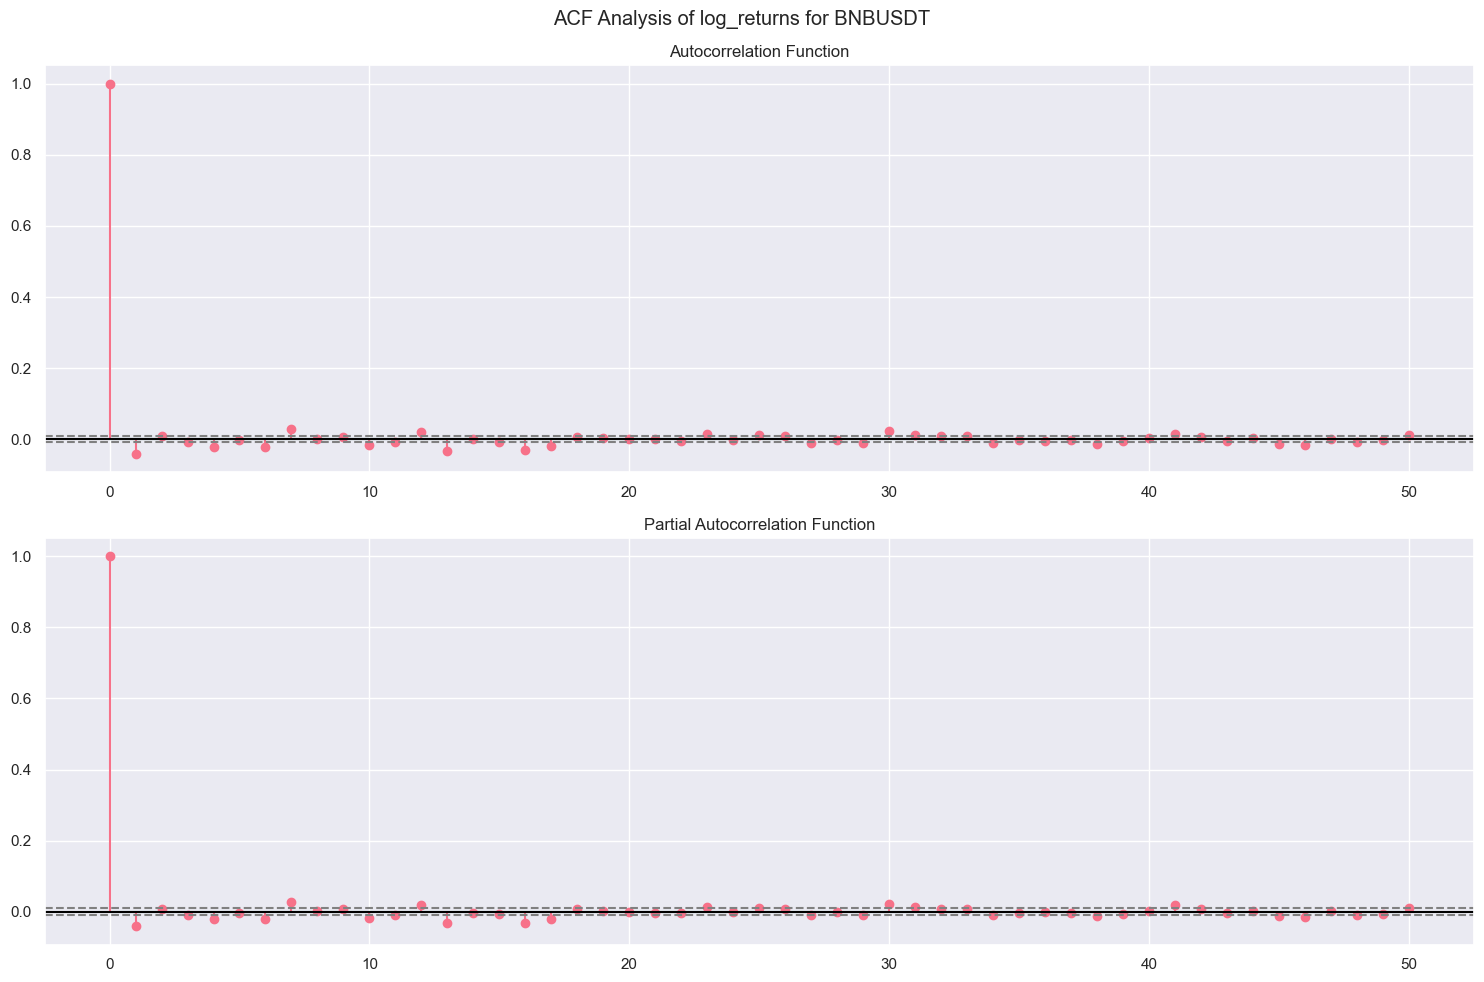

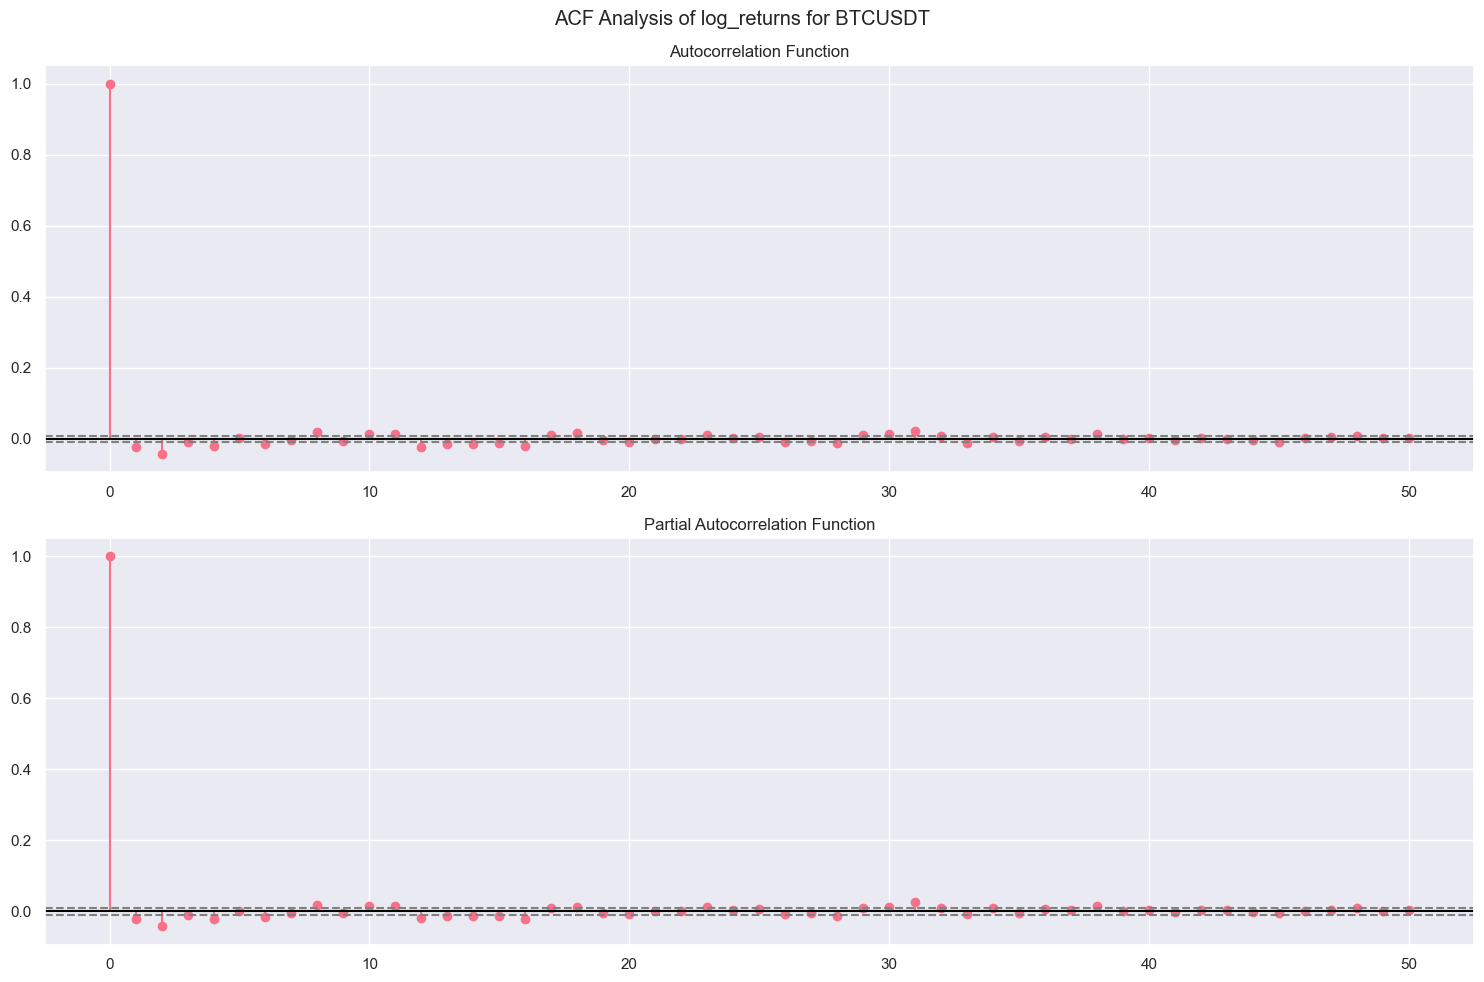

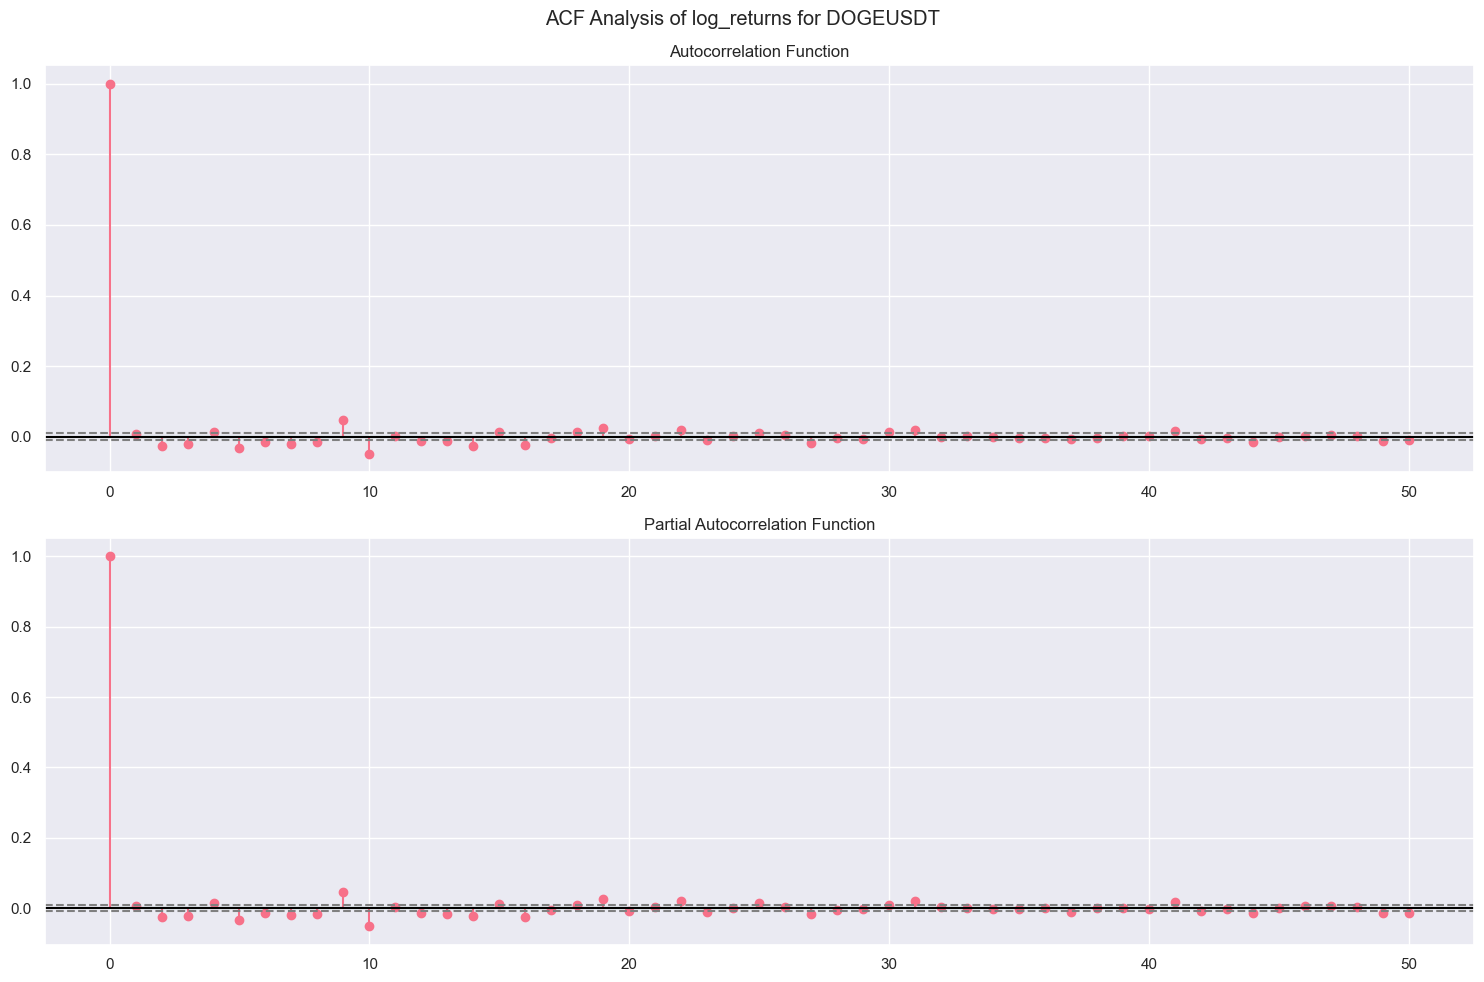

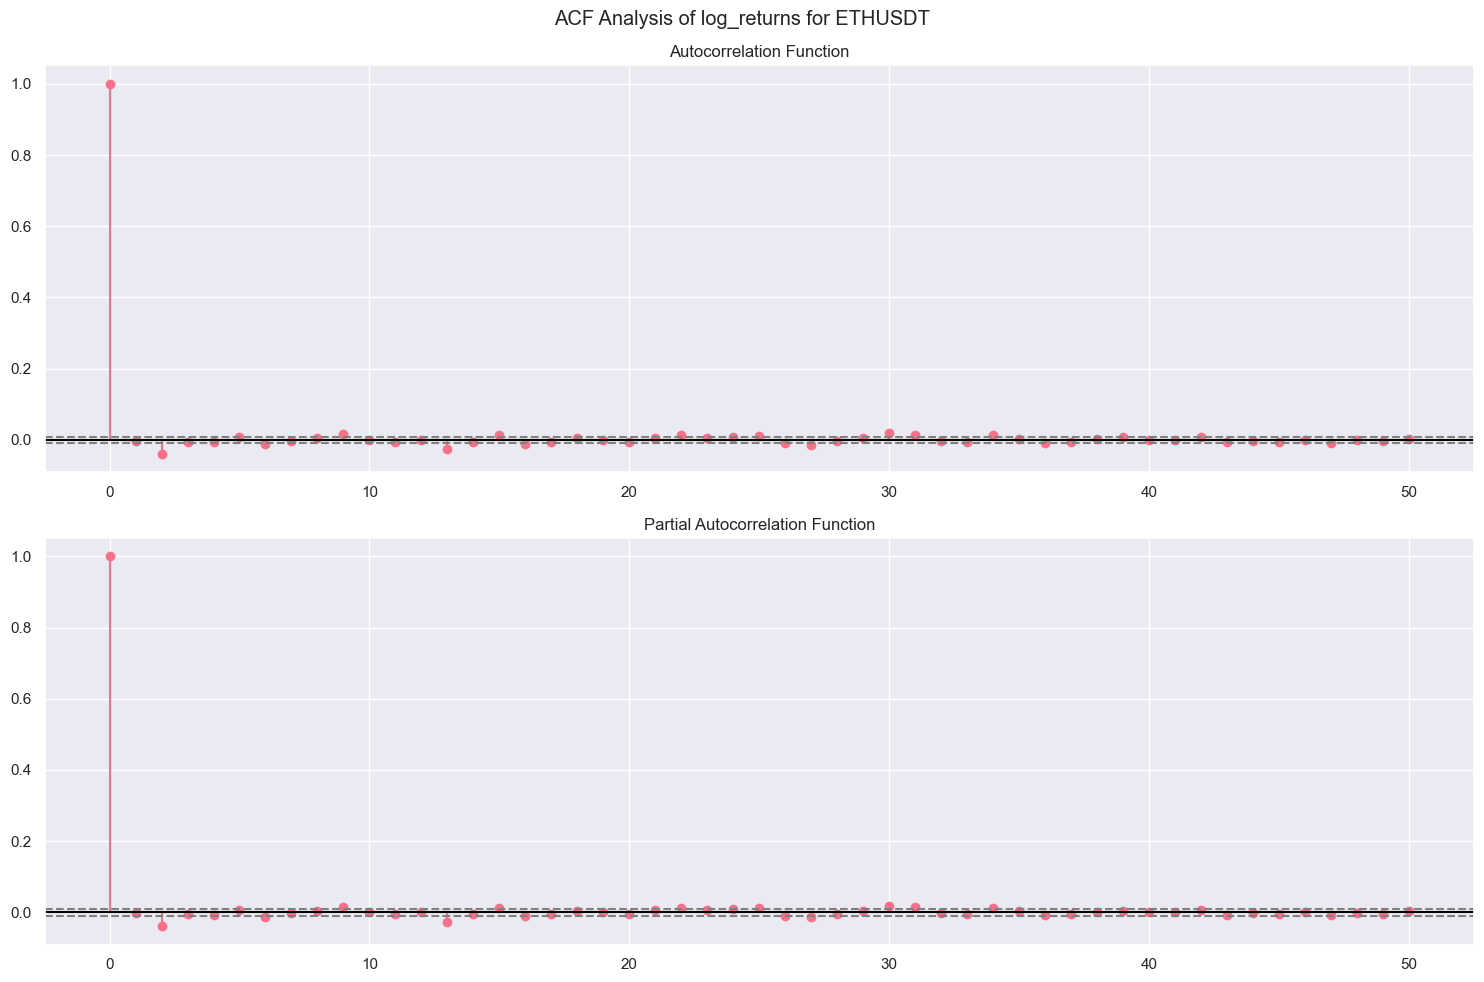

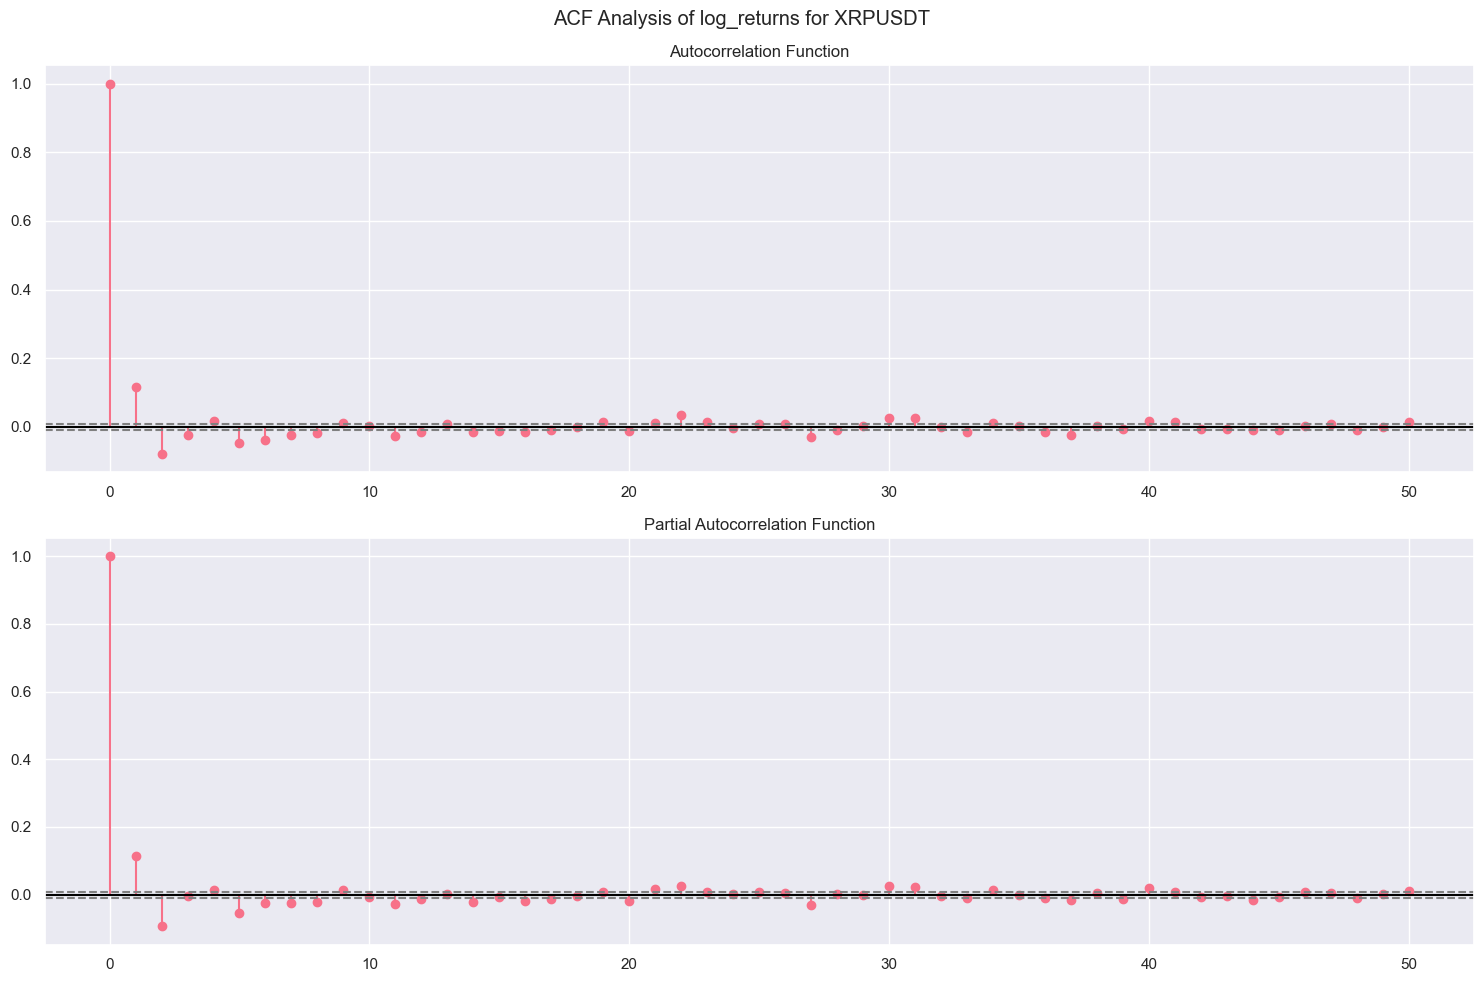


CCF Analysis of Log Returns

Significant lags between ADAUSDT and BNBUSDT:
BNBUSDT leads ADAUSDT by 50 periods (correlation: 0.618)
BNBUSDT leads ADAUSDT by 49 periods (correlation: 0.045)
BNBUSDT leads ADAUSDT by 41 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 34 periods (correlation: -0.018)
BNBUSDT leads ADAUSDT by 31 periods (correlation: 0.012)
BNBUSDT leads ADAUSDT by 27 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 26 periods (correlation: 0.013)
BNBUSDT leads ADAUSDT by 23 periods (correlation: -0.011)
BNBUSDT leads ADAUSDT by 22 periods (correlation: -0.014)
BNBUSDT leads ADAUSDT by 20 periods (correlation: 0.021)
BNBUSDT leads ADAUSDT by 19 periods (correlation: 0.017)
BNBUSDT leads ADAUSDT by 16 periods (correlation: -0.010)
BNBUSDT leads ADAUSDT by 15 periods (correlation: -0.012)
BNBUSDT leads ADAUSDT by 9 periods (correlation: 0.016)
BNBUSDT leads ADAUSDT by 5 periods (correlation: -0.017)
BNBUSDT leads ADAUSDT by 3 periods (correlation: 0.014)
ADAUSDT l

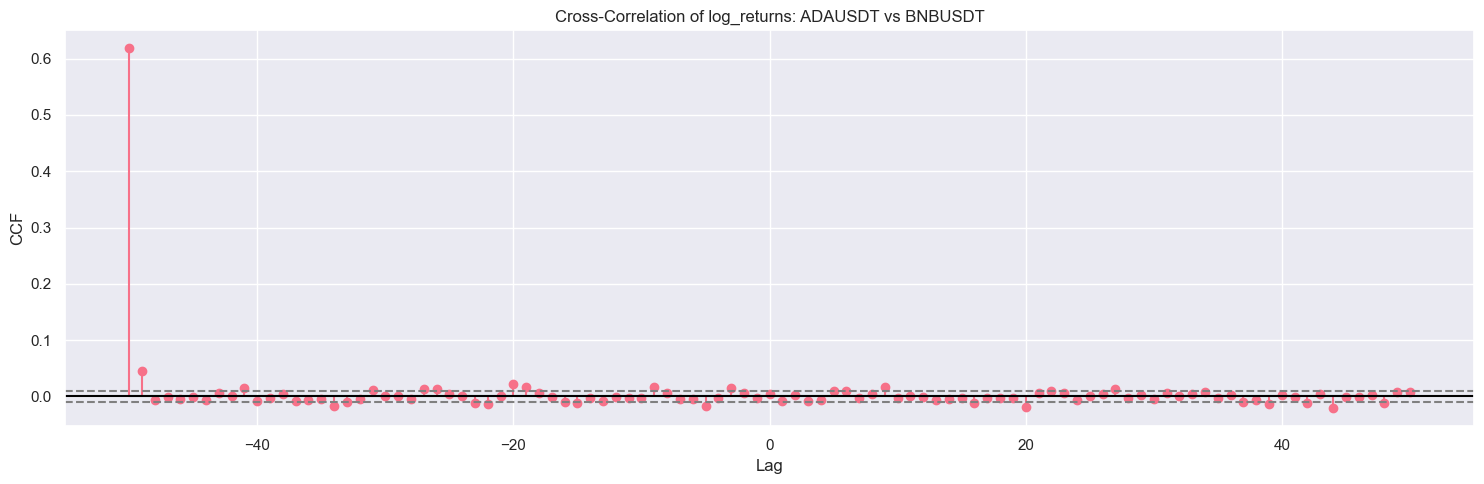


Significant lags between ADAUSDT and BTCUSDT:
BTCUSDT leads ADAUSDT by 50 periods (correlation: 0.716)
BTCUSDT leads ADAUSDT by 49 periods (correlation: 0.043)
BTCUSDT leads ADAUSDT by 48 periods (correlation: -0.025)
BTCUSDT leads ADAUSDT by 44 periods (correlation: -0.013)
BTCUSDT leads ADAUSDT by 43 periods (correlation: 0.011)
BTCUSDT leads ADAUSDT by 41 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 34 periods (correlation: -0.017)
BTCUSDT leads ADAUSDT by 27 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 24 periods (correlation: -0.011)
BTCUSDT leads ADAUSDT by 22 periods (correlation: -0.014)
BTCUSDT leads ADAUSDT by 20 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 19 periods (correlation: 0.020)
BTCUSDT leads ADAUSDT by 12 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 9 periods (correlation: 0.010)
BTCUSDT leads ADAUSDT by 5 periods (correlation: -0.012)
BTCUSDT leads ADAUSDT by 3 periods (correlation: 0.013)
ADAUSDT leads BTCUSDT by 1 periods (co

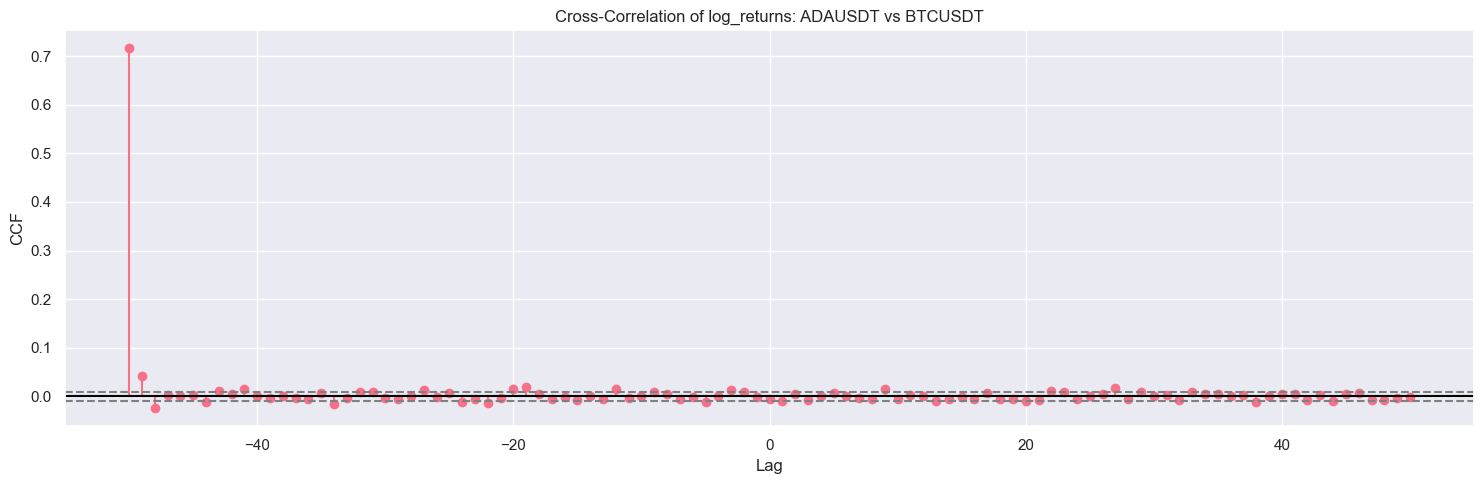


Significant lags between ADAUSDT and DOGEUSDT:
DOGEUSDT leads ADAUSDT by 50 periods (correlation: 0.696)
DOGEUSDT leads ADAUSDT by 49 periods (correlation: 0.029)
DOGEUSDT leads ADAUSDT by 48 periods (correlation: -0.025)
DOGEUSDT leads ADAUSDT by 46 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 45 periods (correlation: -0.010)
DOGEUSDT leads ADAUSDT by 44 periods (correlation: -0.029)
DOGEUSDT leads ADAUSDT by 41 periods (correlation: 0.024)
DOGEUSDT leads ADAUSDT by 40 periods (correlation: -0.013)
DOGEUSDT leads ADAUSDT by 36 periods (correlation: -0.018)
DOGEUSDT leads ADAUSDT by 34 periods (correlation: -0.014)
DOGEUSDT leads ADAUSDT by 32 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 28 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 23 periods (correlation: -0.028)
DOGEUSDT leads ADAUSDT by 20 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 19 periods (correlation: 0.025)
DOGEUSDT leads ADAUSDT by 14 periods (correlation: -0.012)
DOGEUSDT leads A

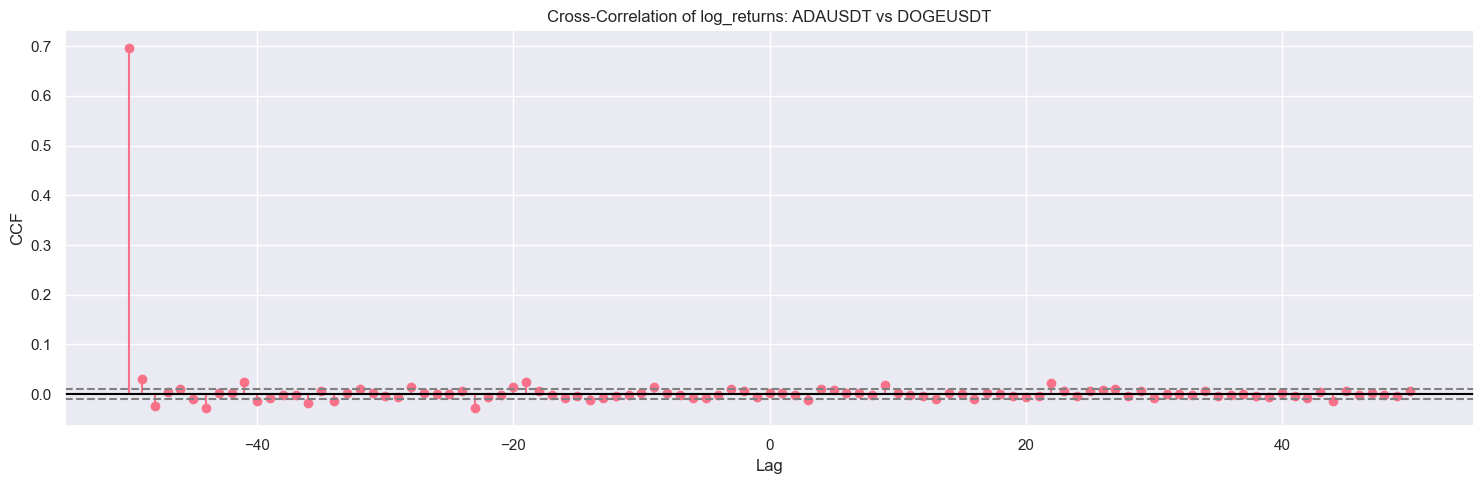


Significant lags between ADAUSDT and ETHUSDT:
ETHUSDT leads ADAUSDT by 50 periods (correlation: 0.752)
ETHUSDT leads ADAUSDT by 49 periods (correlation: 0.036)
ETHUSDT leads ADAUSDT by 48 periods (correlation: -0.023)
ETHUSDT leads ADAUSDT by 46 periods (correlation: 0.013)
ETHUSDT leads ADAUSDT by 44 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 43 periods (correlation: 0.012)
ETHUSDT leads ADAUSDT by 41 periods (correlation: 0.017)
ETHUSDT leads ADAUSDT by 40 periods (correlation: -0.016)
ETHUSDT leads ADAUSDT by 36 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 34 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 30 periods (correlation: -0.013)
ETHUSDT leads ADAUSDT by 27 periods (correlation: 0.015)
ETHUSDT leads ADAUSDT by 23 periods (correlation: -0.017)
ETHUSDT leads ADAUSDT by 22 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 20 periods (correlation: 0.014)
ETHUSDT leads ADAUSDT by 19 periods (correlation: 0.020)
ETHUSDT leads ADAUSDT by 9 period

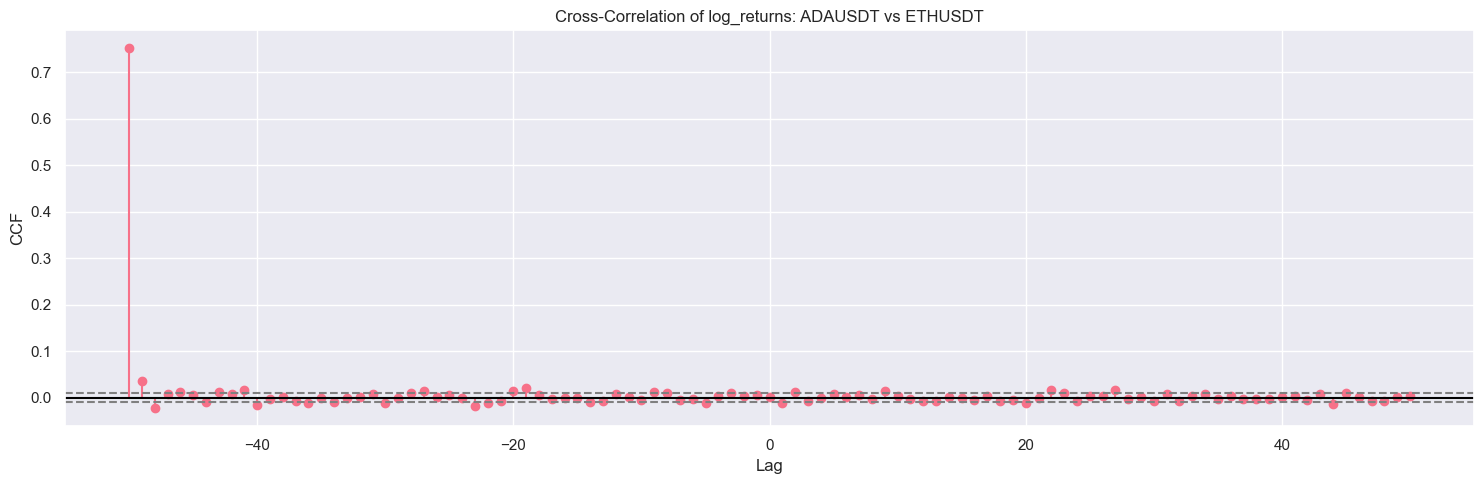


Significant lags between ADAUSDT and XRPUSDT:
XRPUSDT leads ADAUSDT by 50 periods (correlation: 0.685)
XRPUSDT leads ADAUSDT by 49 periods (correlation: 0.031)
XRPUSDT leads ADAUSDT by 48 periods (correlation: -0.036)
XRPUSDT leads ADAUSDT by 47 periods (correlation: 0.020)
XRPUSDT leads ADAUSDT by 45 periods (correlation: -0.024)
XRPUSDT leads ADAUSDT by 44 periods (correlation: -0.028)
XRPUSDT leads ADAUSDT by 42 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 41 periods (correlation: 0.013)
XRPUSDT leads ADAUSDT by 39 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 38 periods (correlation: -0.010)
XRPUSDT leads ADAUSDT by 36 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 30 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 28 periods (correlation: 0.022)
XRPUSDT leads ADAUSDT by 27 periods (correlation: 0.014)
XRPUSDT leads ADAUSDT by 24 periods (correlation: -0.012)
XRPUSDT leads ADAUSDT by 23 periods (correlation: -0.020)
XRPUSDT leads ADAUSDT by 22 per

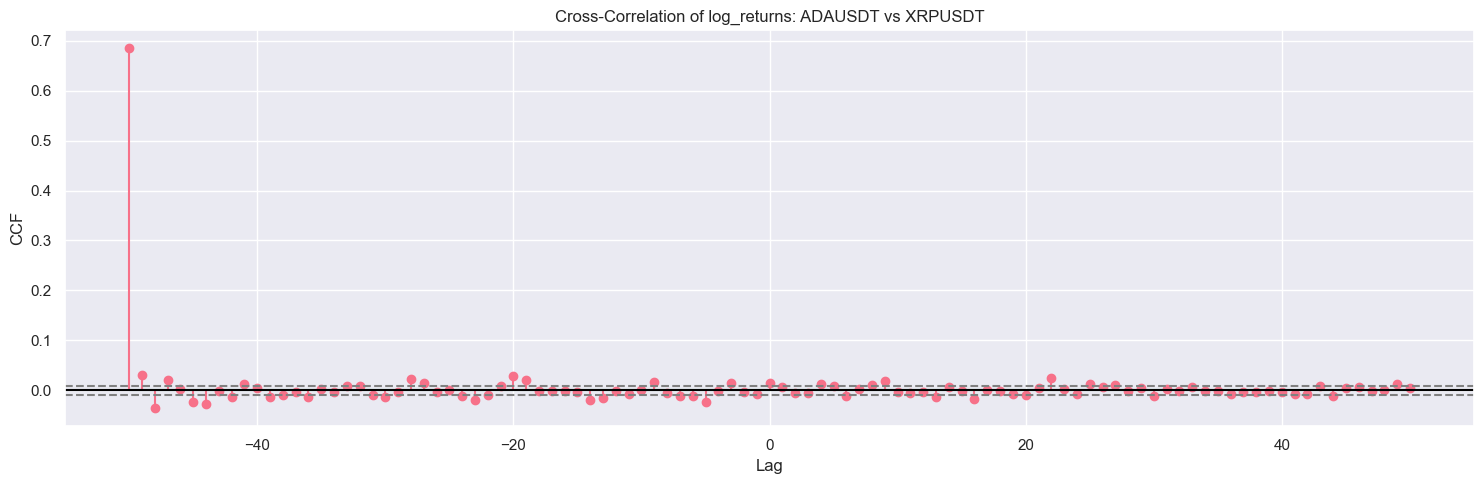


Significant lags between BNBUSDT and BTCUSDT:
BTCUSDT leads BNBUSDT by 50 periods (correlation: 0.578)
BTCUSDT leads BNBUSDT by 49 periods (correlation: 0.019)
BTCUSDT leads BNBUSDT by 44 periods (correlation: -0.013)
BTCUSDT leads BNBUSDT by 43 periods (correlation: 0.015)
BTCUSDT leads BNBUSDT by 42 periods (correlation: 0.013)
BTCUSDT leads BNBUSDT by 38 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 37 periods (correlation: -0.026)
BTCUSDT leads BNBUSDT by 35 periods (correlation: 0.014)
BTCUSDT leads BNBUSDT by 34 periods (correlation: -0.021)
BTCUSDT leads BNBUSDT by 29 periods (correlation: -0.012)
BTCUSDT leads BNBUSDT by 27 periods (correlation: 0.014)
BTCUSDT leads BNBUSDT by 26 periods (correlation: -0.010)
BTCUSDT leads BNBUSDT by 19 periods (correlation: 0.020)
BTCUSDT leads BNBUSDT by 9 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 8 periods (correlation: 0.010)
BNBUSDT leads BTCUSDT by 2 periods (correlation: 0.010)
BNBUSDT leads BTCUSDT by 8 periods (cor

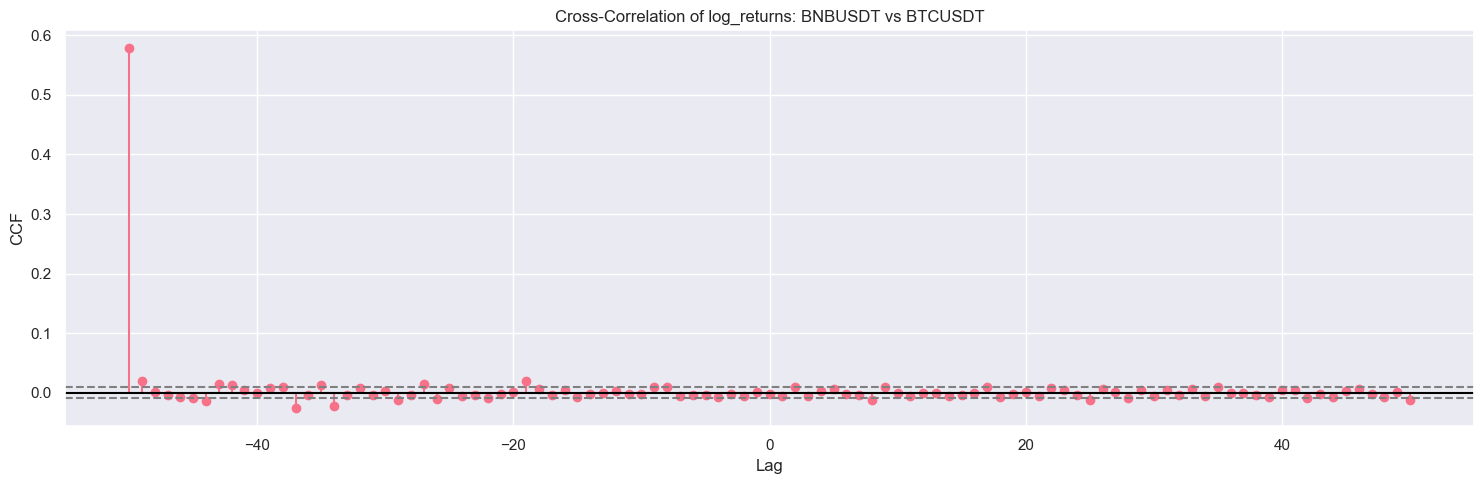


Significant lags between BNBUSDT and DOGEUSDT:
DOGEUSDT leads BNBUSDT by 50 periods (correlation: 0.543)
DOGEUSDT leads BNBUSDT by 49 periods (correlation: 0.018)
DOGEUSDT leads BNBUSDT by 48 periods (correlation: -0.014)
DOGEUSDT leads BNBUSDT by 46 periods (correlation: -0.010)
DOGEUSDT leads BNBUSDT by 45 periods (correlation: -0.016)
DOGEUSDT leads BNBUSDT by 44 periods (correlation: -0.028)
DOGEUSDT leads BNBUSDT by 43 periods (correlation: 0.021)
DOGEUSDT leads BNBUSDT by 37 periods (correlation: -0.040)
DOGEUSDT leads BNBUSDT by 34 periods (correlation: -0.027)
DOGEUSDT leads BNBUSDT by 28 periods (correlation: 0.010)
DOGEUSDT leads BNBUSDT by 27 periods (correlation: 0.009)
DOGEUSDT leads BNBUSDT by 24 periods (correlation: 0.022)
DOGEUSDT leads BNBUSDT by 23 periods (correlation: -0.027)
DOGEUSDT leads BNBUSDT by 19 periods (correlation: 0.026)
DOGEUSDT leads BNBUSDT by 12 periods (correlation: -0.018)
DOGEUSDT leads BNBUSDT by 9 periods (correlation: 0.012)
DOGEUSDT leads BN

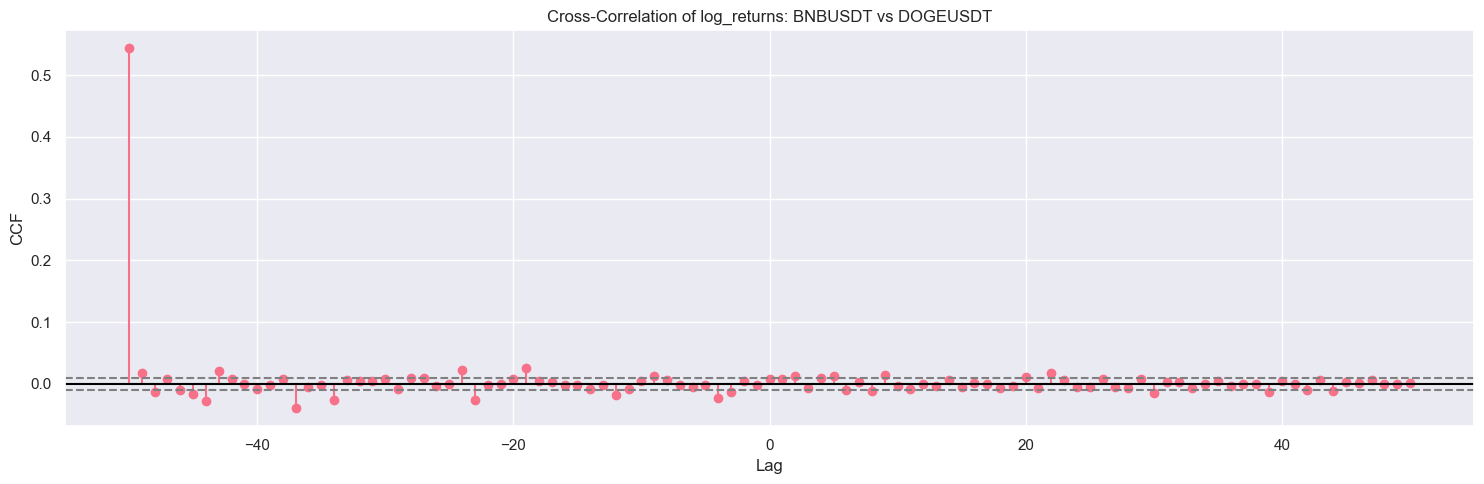


Significant lags between BNBUSDT and ETHUSDT:
ETHUSDT leads BNBUSDT by 50 periods (correlation: 0.615)
ETHUSDT leads BNBUSDT by 49 periods (correlation: 0.010)
ETHUSDT leads BNBUSDT by 44 periods (correlation: -0.018)
ETHUSDT leads BNBUSDT by 43 periods (correlation: 0.022)
ETHUSDT leads BNBUSDT by 42 periods (correlation: 0.013)
ETHUSDT leads BNBUSDT by 40 periods (correlation: -0.010)
ETHUSDT leads BNBUSDT by 37 periods (correlation: -0.028)
ETHUSDT leads BNBUSDT by 34 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 27 periods (correlation: 0.016)
ETHUSDT leads BNBUSDT by 23 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 19 periods (correlation: 0.020)
ETHUSDT leads BNBUSDT by 8 periods (correlation: 0.011)
ETHUSDT leads BNBUSDT by 4 periods (correlation: -0.014)
BNBUSDT leads ETHUSDT by 1 periods (correlation: -0.011)
BNBUSDT leads ETHUSDT by 2 periods (correlation: 0.016)
BNBUSDT leads ETHUSDT by 4 periods (correlation: 0.010)
BNBUSDT leads ETHUSDT by 9 periods (cor

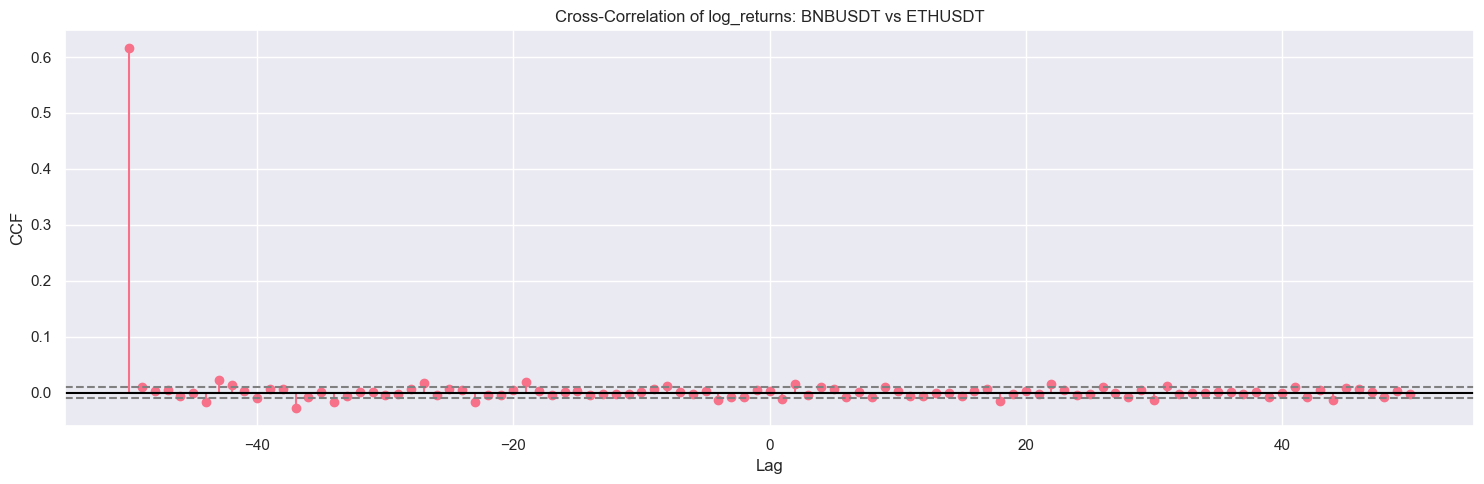


Significant lags between BNBUSDT and XRPUSDT:
XRPUSDT leads BNBUSDT by 50 periods (correlation: 0.516)
XRPUSDT leads BNBUSDT by 49 periods (correlation: 0.012)
XRPUSDT leads BNBUSDT by 48 periods (correlation: -0.012)
XRPUSDT leads BNBUSDT by 47 periods (correlation: 0.017)
XRPUSDT leads BNBUSDT by 46 periods (correlation: -0.020)
XRPUSDT leads BNBUSDT by 45 periods (correlation: -0.036)
XRPUSDT leads BNBUSDT by 44 periods (correlation: -0.016)
XRPUSDT leads BNBUSDT by 43 periods (correlation: 0.020)
XRPUSDT leads BNBUSDT by 42 periods (correlation: -0.012)
XRPUSDT leads BNBUSDT by 38 periods (correlation: -0.012)
XRPUSDT leads BNBUSDT by 37 periods (correlation: -0.030)
XRPUSDT leads BNBUSDT by 34 periods (correlation: -0.021)
XRPUSDT leads BNBUSDT by 32 periods (correlation: 0.010)
XRPUSDT leads BNBUSDT by 31 periods (correlation: -0.010)
XRPUSDT leads BNBUSDT by 28 periods (correlation: 0.015)
XRPUSDT leads BNBUSDT by 27 periods (correlation: 0.023)
XRPUSDT leads BNBUSDT by 23 peri

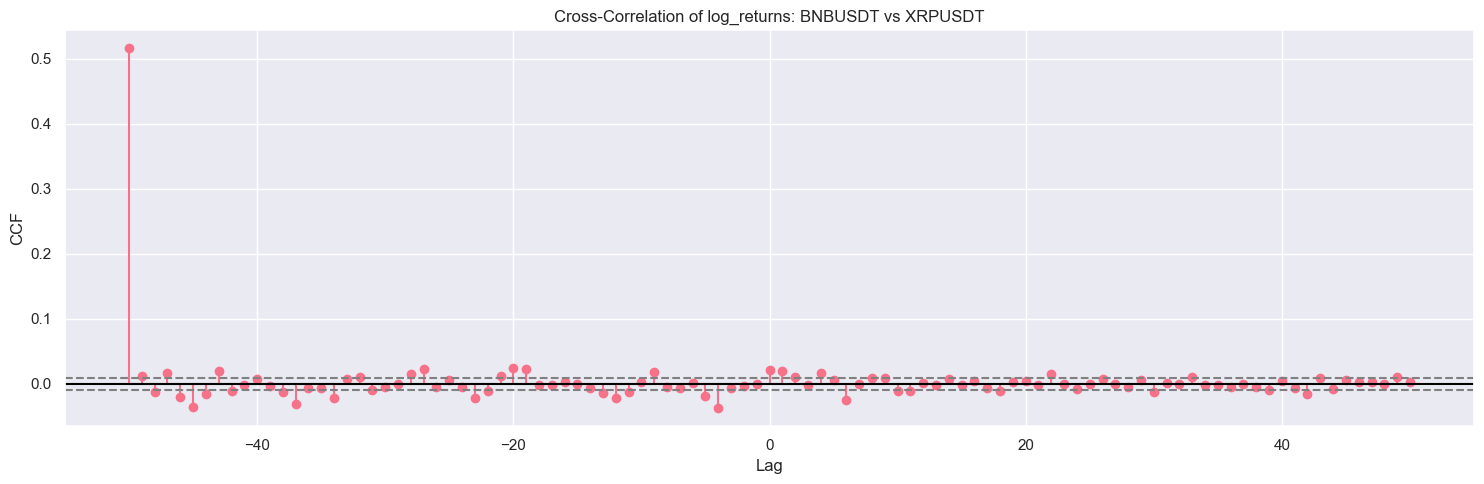


Significant lags between BTCUSDT and DOGEUSDT:
DOGEUSDT leads BTCUSDT by 50 periods (correlation: 0.615)
DOGEUSDT leads BTCUSDT by 49 periods (correlation: -0.012)
DOGEUSDT leads BTCUSDT by 48 periods (correlation: -0.048)
DOGEUSDT leads BTCUSDT by 46 periods (correlation: -0.010)
DOGEUSDT leads BTCUSDT by 45 periods (correlation: -0.016)
DOGEUSDT leads BTCUSDT by 44 periods (correlation: -0.029)
DOGEUSDT leads BTCUSDT by 43 periods (correlation: -0.012)
DOGEUSDT leads BTCUSDT by 42 periods (correlation: 0.027)
DOGEUSDT leads BTCUSDT by 37 periods (correlation: -0.019)
DOGEUSDT leads BTCUSDT by 36 periods (correlation: -0.020)
DOGEUSDT leads BTCUSDT by 35 periods (correlation: -0.011)
DOGEUSDT leads BTCUSDT by 34 periods (correlation: -0.013)
DOGEUSDT leads BTCUSDT by 33 periods (correlation: 0.014)
DOGEUSDT leads BTCUSDT by 23 periods (correlation: -0.018)
DOGEUSDT leads BTCUSDT by 20 periods (correlation: 0.017)
DOGEUSDT leads BTCUSDT by 19 periods (correlation: 0.017)
DOGEUSDT lead

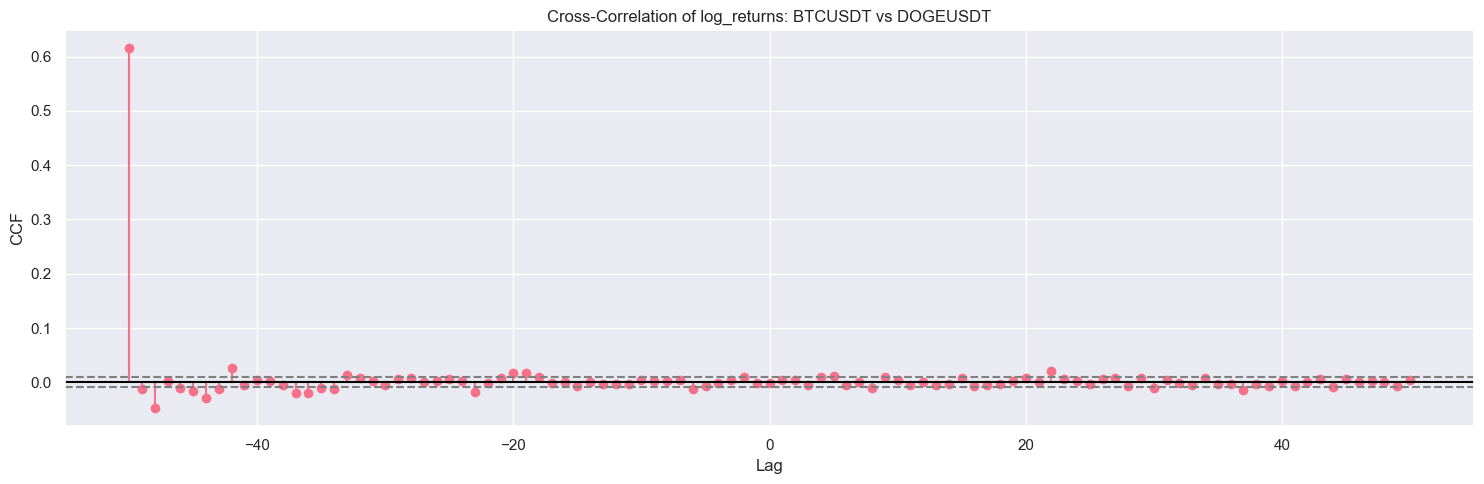


Significant lags between BTCUSDT and ETHUSDT:
ETHUSDT leads BTCUSDT by 50 periods (correlation: 0.796)
ETHUSDT leads BTCUSDT by 49 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 48 periods (correlation: -0.049)
ETHUSDT leads BTCUSDT by 46 periods (correlation: -0.011)
ETHUSDT leads BTCUSDT by 44 periods (correlation: -0.018)
ETHUSDT leads BTCUSDT by 42 periods (correlation: 0.016)
ETHUSDT leads BTCUSDT by 41 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 39 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 38 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 37 periods (correlation: -0.019)
ETHUSDT leads BTCUSDT by 36 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 35 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 34 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 30 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 28 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 24 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 23 p

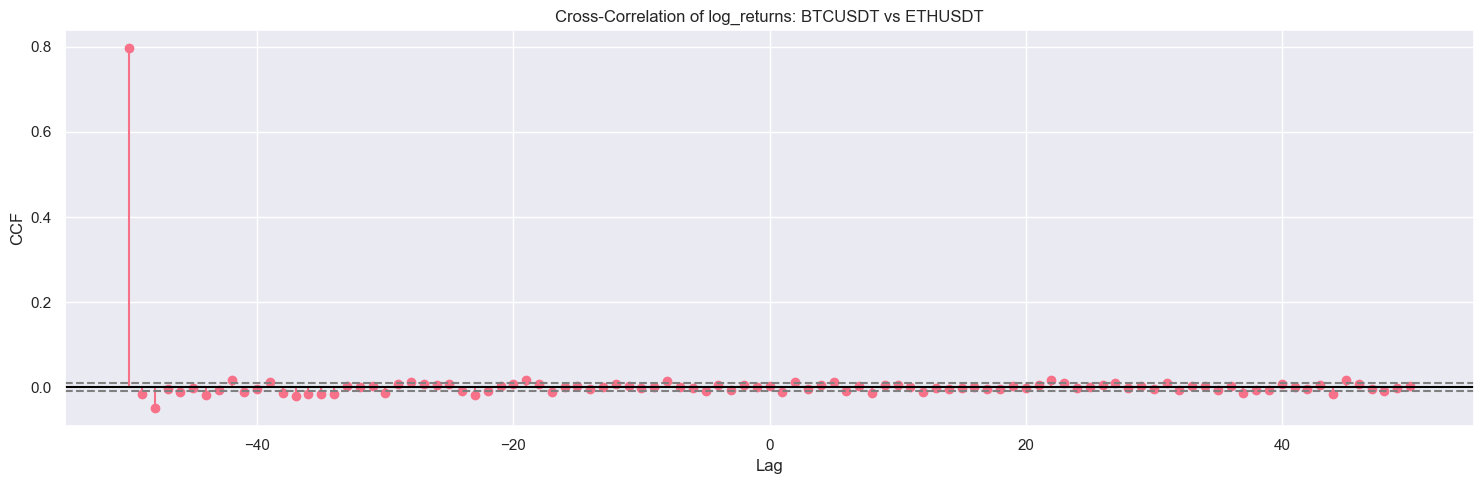


Significant lags between BTCUSDT and XRPUSDT:
XRPUSDT leads BTCUSDT by 50 periods (correlation: 0.593)
XRPUSDT leads BTCUSDT by 49 periods (correlation: -0.044)
XRPUSDT leads BTCUSDT by 48 periods (correlation: -0.038)
XRPUSDT leads BTCUSDT by 47 periods (correlation: 0.016)
XRPUSDT leads BTCUSDT by 46 periods (correlation: -0.025)
XRPUSDT leads BTCUSDT by 45 periods (correlation: -0.032)
XRPUSDT leads BTCUSDT by 44 periods (correlation: -0.030)
XRPUSDT leads BTCUSDT by 43 periods (correlation: -0.016)
XRPUSDT leads BTCUSDT by 42 periods (correlation: 0.011)
XRPUSDT leads BTCUSDT by 40 periods (correlation: 0.015)
XRPUSDT leads BTCUSDT by 38 periods (correlation: -0.017)
XRPUSDT leads BTCUSDT by 37 periods (correlation: -0.014)
XRPUSDT leads BTCUSDT by 36 periods (correlation: -0.016)
XRPUSDT leads BTCUSDT by 35 periods (correlation: -0.012)
XRPUSDT leads BTCUSDT by 33 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 28 periods (correlation: 0.009)
XRPUSDT leads BTCUSDT by 27 per

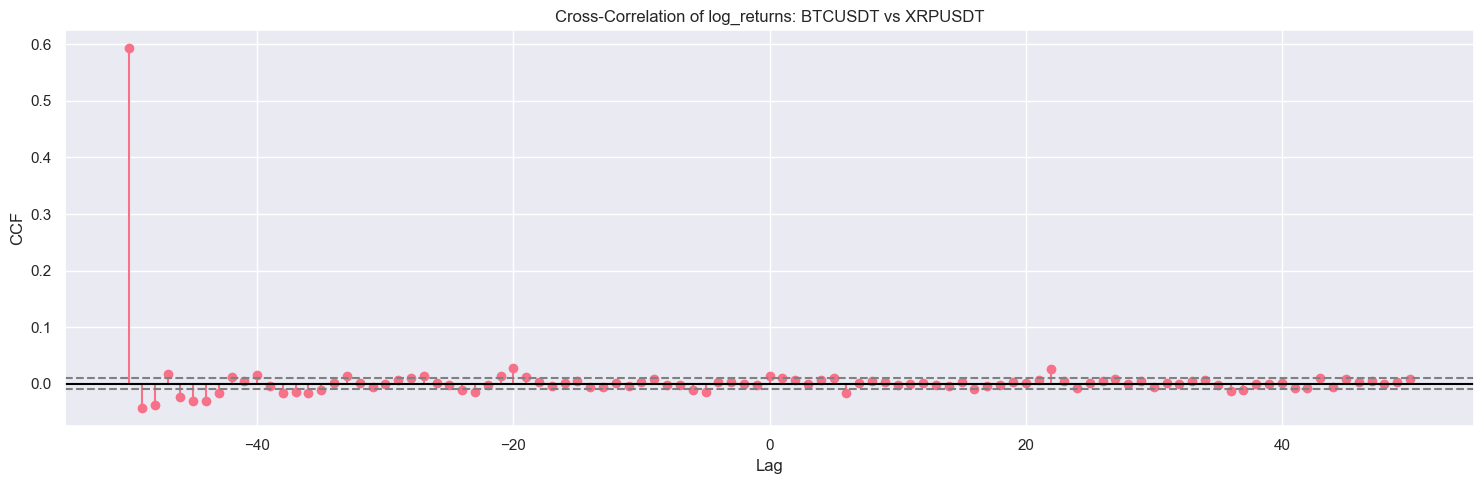


Significant lags between DOGEUSDT and ETHUSDT:
ETHUSDT leads DOGEUSDT by 50 periods (correlation: 0.654)
ETHUSDT leads DOGEUSDT by 49 periods (correlation: 0.045)
ETHUSDT leads DOGEUSDT by 48 periods (correlation: -0.036)
ETHUSDT leads DOGEUSDT by 46 periods (correlation: 0.016)
ETHUSDT leads DOGEUSDT by 45 periods (correlation: -0.009)
ETHUSDT leads DOGEUSDT by 41 periods (correlation: 0.035)
ETHUSDT leads DOGEUSDT by 40 periods (correlation: -0.032)
ETHUSDT leads DOGEUSDT by 37 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 36 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 34 periods (correlation: -0.013)
ETHUSDT leads DOGEUSDT by 30 periods (correlation: -0.025)
ETHUSDT leads DOGEUSDT by 28 periods (correlation: 0.012)
ETHUSDT leads DOGEUSDT by 23 periods (correlation: -0.018)
ETHUSDT leads DOGEUSDT by 20 periods (correlation: 0.014)
ETHUSDT leads DOGEUSDT by 19 periods (correlation: 0.021)
ETHUSDT leads DOGEUSDT by 16 periods (correlation: 0.013)
ETHUSDT leads DO

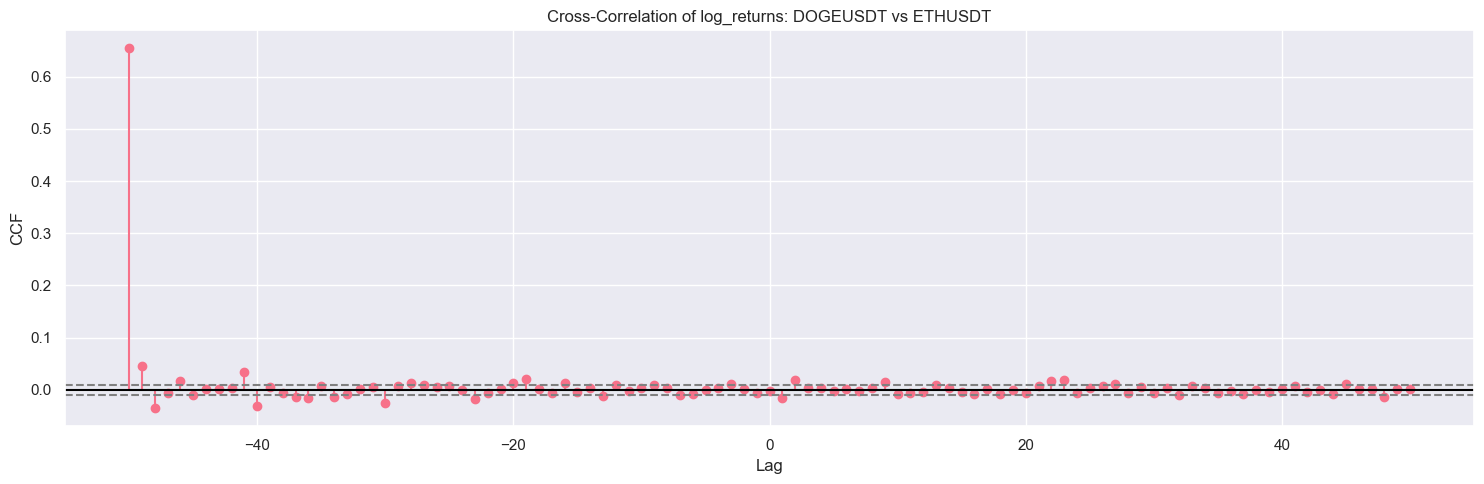


Significant lags between DOGEUSDT and XRPUSDT:
XRPUSDT leads DOGEUSDT by 50 periods (correlation: 0.662)
XRPUSDT leads DOGEUSDT by 49 periods (correlation: 0.024)
XRPUSDT leads DOGEUSDT by 48 periods (correlation: -0.056)
XRPUSDT leads DOGEUSDT by 46 periods (correlation: -0.010)
XRPUSDT leads DOGEUSDT by 45 periods (correlation: -0.034)
XRPUSDT leads DOGEUSDT by 44 periods (correlation: -0.010)
XRPUSDT leads DOGEUSDT by 43 periods (correlation: -0.018)
XRPUSDT leads DOGEUSDT by 42 periods (correlation: -0.027)
XRPUSDT leads DOGEUSDT by 41 periods (correlation: 0.027)
XRPUSDT leads DOGEUSDT by 39 periods (correlation: -0.014)
XRPUSDT leads DOGEUSDT by 38 periods (correlation: -0.017)
XRPUSDT leads DOGEUSDT by 37 periods (correlation: -0.013)
XRPUSDT leads DOGEUSDT by 36 periods (correlation: -0.020)
XRPUSDT leads DOGEUSDT by 35 periods (correlation: 0.018)
XRPUSDT leads DOGEUSDT by 32 periods (correlation: 0.011)
XRPUSDT leads DOGEUSDT by 30 periods (correlation: -0.017)
XRPUSDT leads

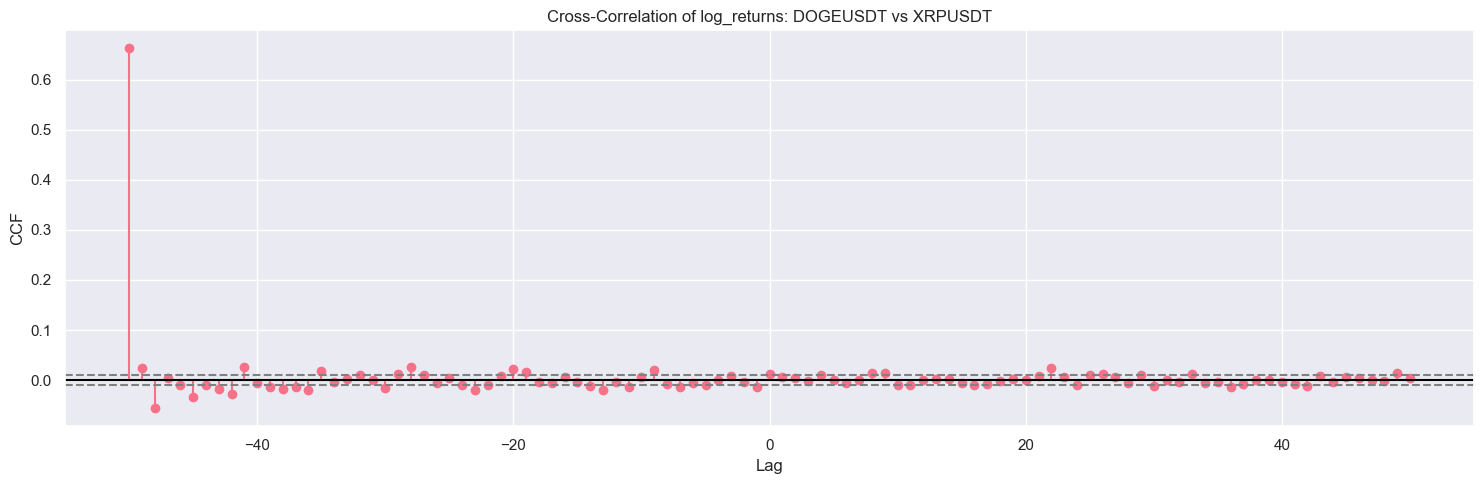


Significant lags between ETHUSDT and XRPUSDT:
XRPUSDT leads ETHUSDT by 50 periods (correlation: 0.635)
XRPUSDT leads ETHUSDT by 49 periods (correlation: -0.015)
XRPUSDT leads ETHUSDT by 48 periods (correlation: -0.061)
XRPUSDT leads ETHUSDT by 46 periods (correlation: -0.023)
XRPUSDT leads ETHUSDT by 45 periods (correlation: -0.019)
XRPUSDT leads ETHUSDT by 44 periods (correlation: -0.020)
XRPUSDT leads ETHUSDT by 43 periods (correlation: -0.018)
XRPUSDT leads ETHUSDT by 41 periods (correlation: 0.022)
XRPUSDT leads ETHUSDT by 40 periods (correlation: 0.015)
XRPUSDT leads ETHUSDT by 39 periods (correlation: -0.011)
XRPUSDT leads ETHUSDT by 37 periods (correlation: -0.023)
XRPUSDT leads ETHUSDT by 35 periods (correlation: 0.017)
XRPUSDT leads ETHUSDT by 32 periods (correlation: 0.011)
XRPUSDT leads ETHUSDT by 31 periods (correlation: -0.012)
XRPUSDT leads ETHUSDT by 28 periods (correlation: 0.013)
XRPUSDT leads ETHUSDT by 24 periods (correlation: -0.015)
XRPUSDT leads ETHUSDT by 23 per

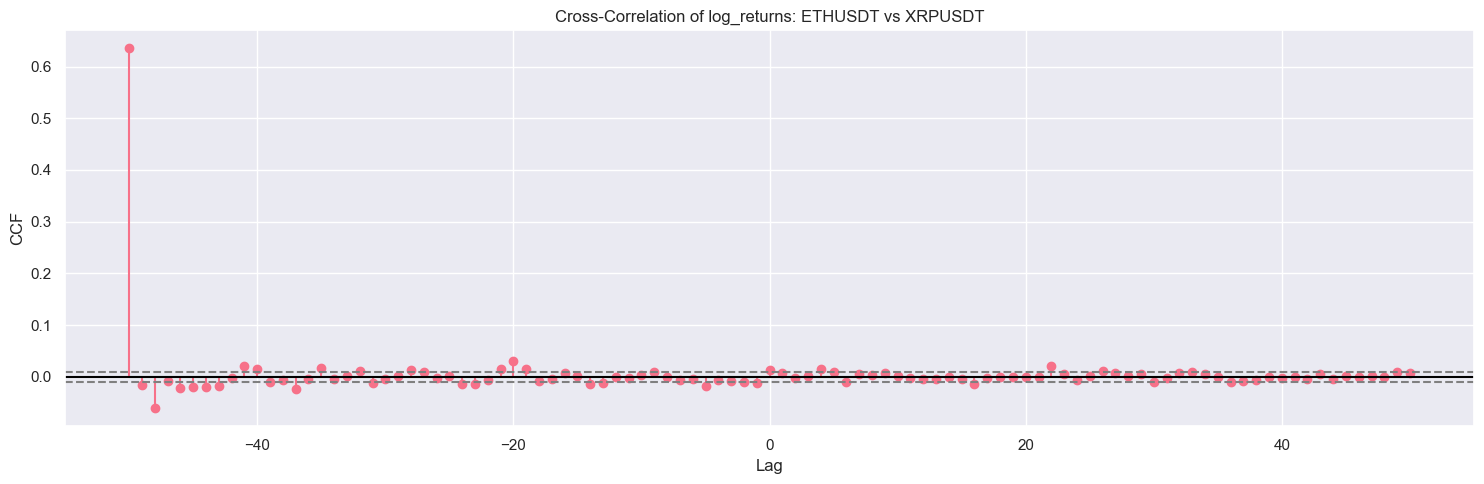

In [30]:
# Load data
all_data, returns_data = load_and_prepare_data()

# Plot ACF analysis for log returns
print("ACF Analysis of Log Returns")
plot_acf_analysis(returns_data, diff_type="log_returns")

# Plot CCF analysis for log returns
print("\nCCF Analysis of Log Returns")
plot_ccf_analysis(returns_data, diff_type="log_returns")

## Additional Analysis: Returns Distribution

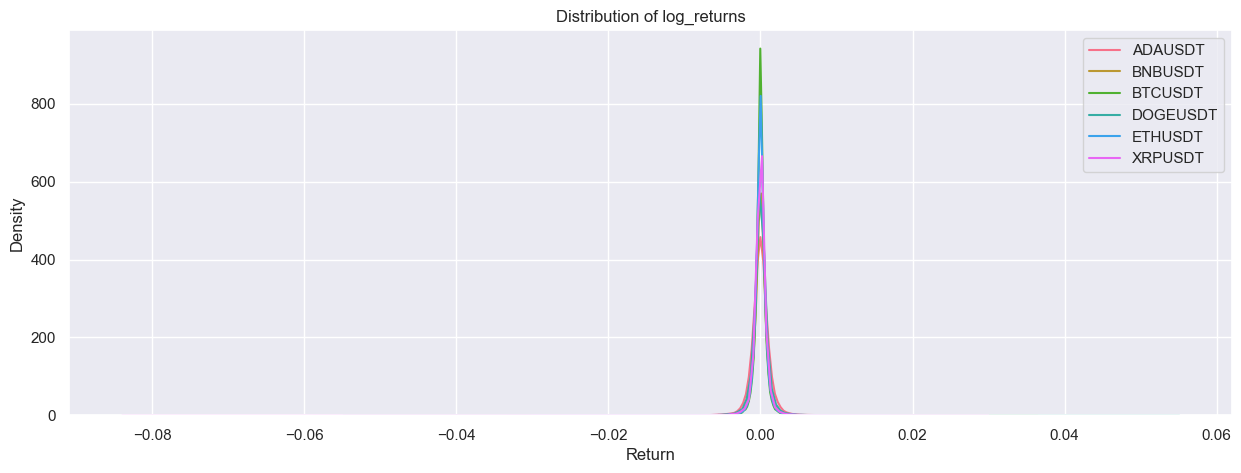

In [31]:
def plot_returns_distribution(returns_data, diff_type="log_returns"):
    plt.figure(figsize=(15, 5))

    for symbol, df in returns_data.items():
        sns.kdeplot(data=df[diff_type].dropna(), label=symbol)

    plt.title(f"Distribution of {diff_type}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


plot_returns_distribution(returns_data, "log_returns")

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    combined_returns.corr(),
    annot=True,
    cmap='RdYlBu',
    center=0,
    fmt='.2f'
)
plt.title('Correlation Heatmap of Crypto Returns')
plt.tight_layout()
plt.show()